<a href="https://colab.research.google.com/github/Hani1-2/DeepLearningAssignmnt/blob/master/ai_powered_license_plate_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-4-adf02908ab82>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 15))


<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

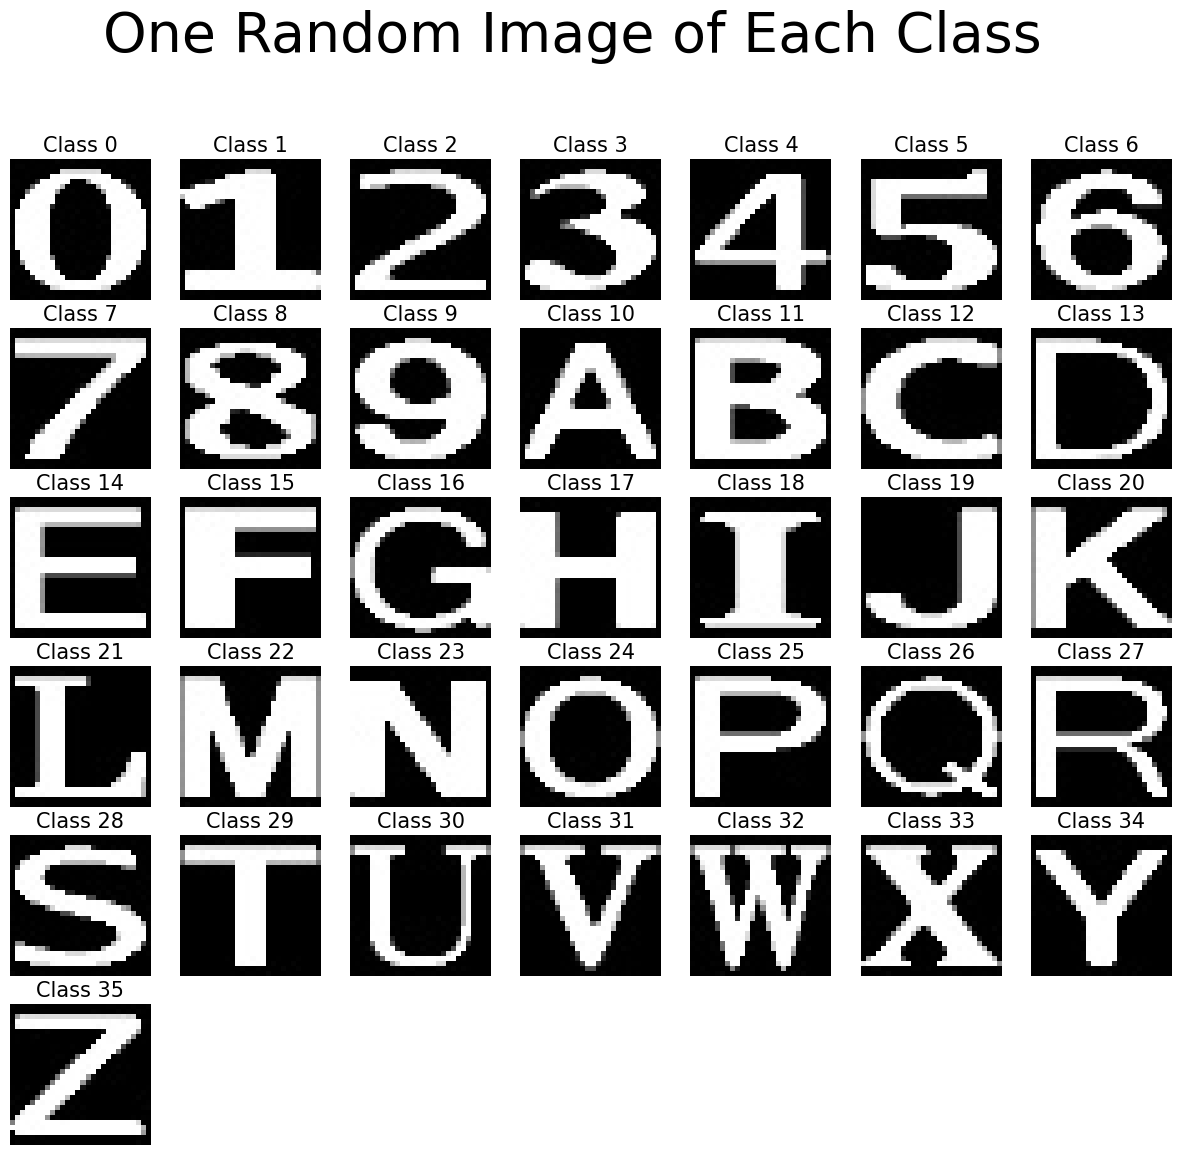

In [4]:
# Display Dataset
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
data_dir = '/content/drive/MyDrive/CV_Project/data/train'
classes = 36
class_names = []
alphabets = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
for i in range(classes):
    class_names.append(f'class_{alphabets[i]}')
    plt.figure(figsize=(15, 15))
    plt.suptitle("One Random Image of Each Class", fontsize=40)
for i in range(classes):
    path = os.path.join(data_dir, class_names[i])
    images = os.listdir(path)
    ax = plt.subplot(7, 7, i+1)
    ax.set_title(f"Class {i}", fontsize=15)
    plt.imshow(Image.open(os.path.join(path, images[random.randint(0, len(images)-1)])))
    plt.axis("off")

In [5]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/CV_Project/indian_license_plate.xml')
# add the path to 'india_license_plate.xml' file.

In [6]:
def detect_plate(img): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-10, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    return plate_img, plate # returning the processed image.

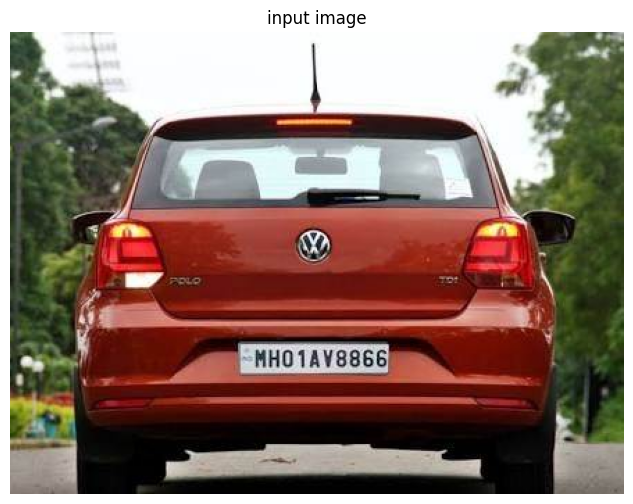

In [7]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('/content/car_image.jpg')
display(img, 'input image')

In [8]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)

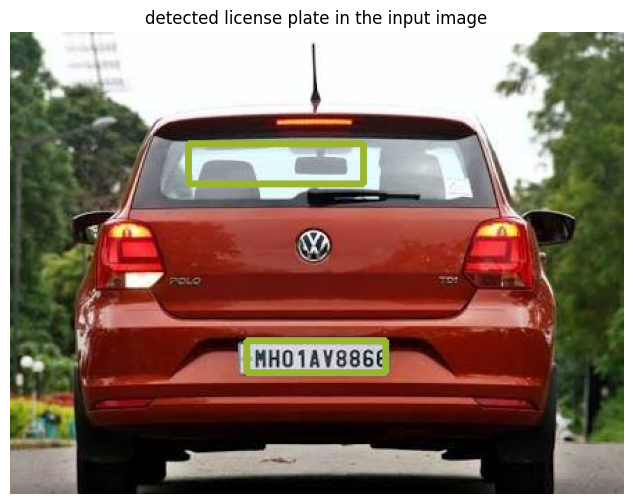

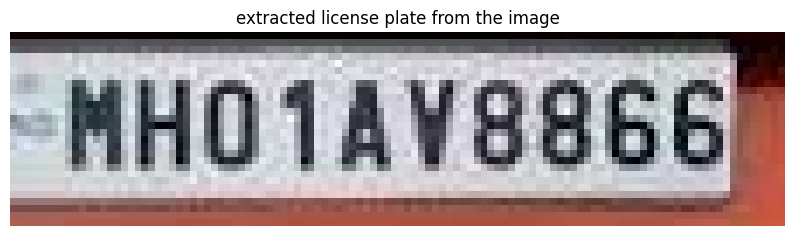

In [9]:
display(output_img, 'detected license plate in the input image')
display(plate, 'extracted license plate from the image')

In [10]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [11]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

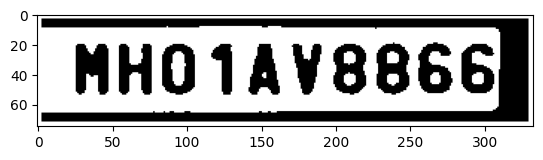

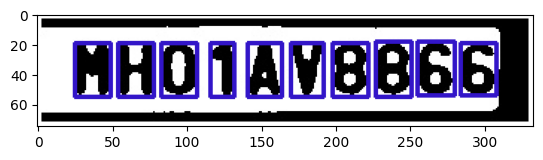

In [12]:
# Let's see the segmented characters
char = segment_characters(plate)

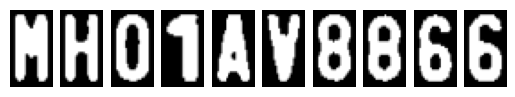

In [13]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for characters

In [14]:
import tensorflow as tf
# tf.enable_eager_execution()
tf.executing_eagerly()

True

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/CV_Project/data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/CV_Project/data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [16]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (20,20), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

In [17]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.992):
      self.model.stop_training = True

In [18]:
import datetime
!rm -rf logs
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]
history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs = 80, callbacks=callbacks)

<ipython-input-19-0cf4bf9bc262>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/80
863/864 [============================>.] - ETA: 0s - loss: 2.3378 - accuracy: 0.3615

864/864 [==============================] - 27s 30ms/step - loss: 2.3389 - accuracy: 0.3611 - val_loss: 0.9531 - val_accuracy: 0.6991
Epoch 2/80
864/864 [==============================] - 22s 25ms/step - loss: 0.9367 - accuracy: 0.7350
Epoch 3/80
864/864 [==============================] - 23s 26ms/step - loss: 0.6571 - accuracy: 0.8310
Epoch 4/80
864/864 [==============================] - 24s 27ms/step - loss: 0.5242 - accuracy: 0.8519
Epoch 5/80
864/864 [==============================] - 24s 28ms/step - loss: 0.4445 - accuracy: 0.8669
Epoch 6/80
864/864 [==============================] - 24s 28ms/step - loss: 0.3930 - accuracy: 0.8785
Epoch 7/80
864/864 [==============================] - 24s 27ms/step - loss: 0.4070 - accuracy: 0.9039
Epoch 8/80
864/864 [==============================] - 24s 27ms/step - loss: 0.4706 - accuracy: 0.8796
Epoch 9/80
864/864 [==============================] - 23s 27ms/step - loss: 0.3784 - accuracy: 0.8993
Epoch 10/80
864/864 [==============================

In [20]:
model.save('/content/drive/MyDrive/CV_Project/model_cnn.h5')

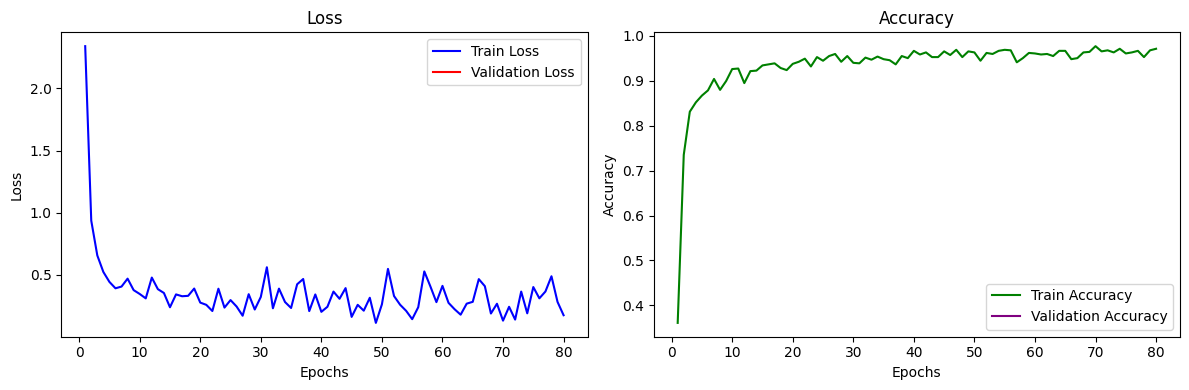

In [26]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting the loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, color='blue', label='Train Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, color='red', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, color='green', label='Train Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, color='purple', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# !kill 8400
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [17]:
from tensorflow.keras.models import load_model
model = load_model('/content/model_cnn.h5')

In [18]:
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model

        # y_ = model.predict_classes(img)[0] #predicting the class
        y_ = np.argmax(model.predict(img), axis=-1)[0]

        character = dic[y_] #
        output.append(character) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number

print(show_results())

1/1 [==============================] - 0s 42ms/step
HH01AY8866


1/1 [==============================] - 0s 26ms/step


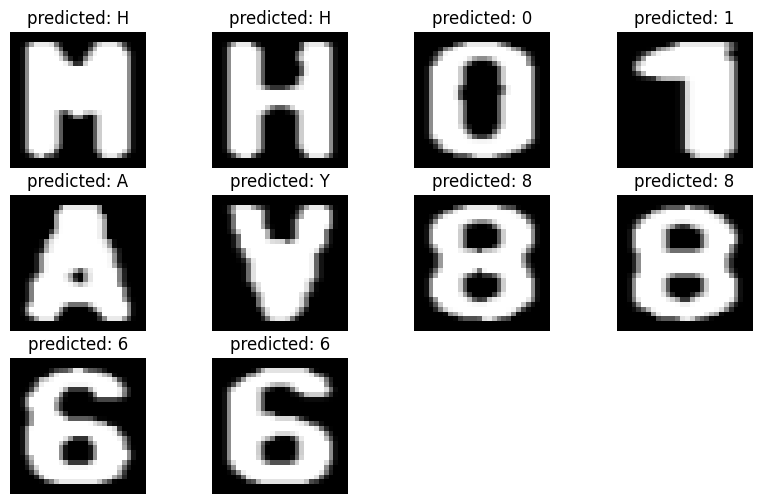

In [19]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()